In [108]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

c:\Users\User\miniconda3\envs\infnet-nn\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


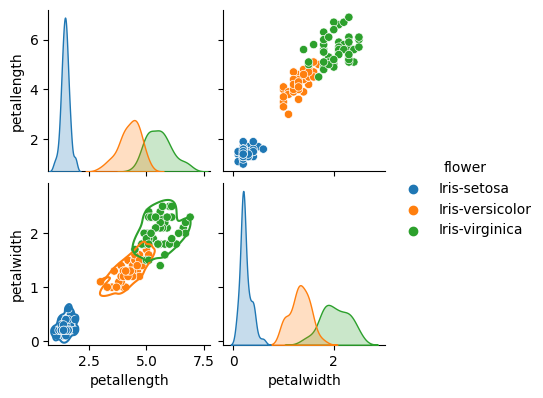

In [109]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'
my_class = 'Iris-versicolor' # 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

# TRAINING PARAMETERS
max_hidden_neurons = 5
hidden_neuron_activation = 'sigmoid'
my_metric = 'Precision' # 'Precision', 'Recall'
my_patience = 200
max_epoch = 10*my_patience
min_improvement = 0.01
min_neuron_gain = 0.01
min_median_gain = 0.01
rmsprop_lr = 0.01
adam_initial_lr = 0.01
adam_decay_steps = max_epoch
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True

# CONTROL RANDOMNESS
random_seed = 33
n_k_folds = 5

# SELECTION FROM IRIS DATAFRAME
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv('iris.data')
iris = iris[my_vars_w_class]

# SCATTER PLOT
_ = g = seaborn.pairplot(iris, hue='flower', height=2, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [110]:
# ROBUST TRAINING PROCEDURE

# OPTIMIZERS TO COMPARE
adam_lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                          adam_decay_steps,
                                                                          adam_lr_decay)

my_optimizers = {'adam': tensorflow.keras.optimizers.legacy.Adam(learning_rate=adam_lr_schedule),
                 'rmsprop': tensorflow.keras.optimizers.legacy.RMSprop(learning_rate=rmsprop_lr)}

# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# PREPARE DATA
X = iris[my_vars].to_numpy()
if my_class not in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    print(f'Classe {my_class} não encontrada! Digite uma das seguintes classes: Iris-setosa, Iris-versicolor, Iris-virginica')
else:
    Y = (iris['flower'] == my_class).astype(float).to_numpy()[:, numpy.newaxis] # 0 / 1

    # NORMALIZE VARIABLES
    X_scaler = StandardScaler()
    X_scaler = X_scaler.fit(X)
    X_scaled = X_scaler.transform(X)

    # GET STRATIFIED FOLDS
    sk_folds = StratifiedKFold(n_splits=n_k_folds)
    sk_folds.get_n_splits(X_scaled, Y)

    # TRAINING LOOP
    # FOR EACH OPTIMIZER
    best_net_name = None
    best_net = None
    best_metric = 0.0
    best_metric_val = 0.0
    metric_lower_bound = 0.0
    metric_median = 0.0
    result_list = []
    print('TRAINING PROCEDURE STARTED...\n')
    for n_neuron in numpy.arange(1, max_hidden_neurons+1):
        # FOR 1 TO MAX_HIDDEN_NEURONS
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y):
            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            
            for optimizer in my_optimizers.keys():
                # DECLARE NET
                inputs = keras.Input(shape=(len(my_vars), ))
                hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
                outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
                model_name = '{}-N{}F{}_{}'.format(optimizer.upper(), n_neuron, ix_fold, my_class)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                if my_metric == 'Accuracy':
                    metric_name = my_metric
                else:
                    metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max', patience=n_k_folds*my_patience, min_delta=min_improvement)
                
                # FIT W CLASS WEIGHTS
                my_class_weight = Y_train.shape[0]/Y_train.sum()
                other_class_weight = Y_train.shape[0]/(Y_train==0).sum()
                class_weights = {0: other_class_weight, 1: my_class_weight}
                history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric, es_val_metric], class_weight=class_weights)

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_net = my_net
                    best_neurons = n_neuron
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'
                    is_best = True

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'neurons': n_neuron, 'fold': ix_fold, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)

                print('{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name, n_epochs, model_loss, model_val_loss, metric_name,
                                                                                                    100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            print('')
            ix_fold += 1
            
        # TEST IF MORE NEURONS ARE NECESSARY
        dont_need_extra_neurons = False
        if n_neuron > 1:
            
            # INCREASING NEURONS DIDNT ACHIEVE BEST NET
            if best_neurons < n_neuron:
                dont_need_extra_neurons = True
                print('NETs w {} neurons didnt improve {}!'.format(n_neuron, metric_name))
                break

        # GET LOWER BOUND OF WINNING ALGORITHM
        df_results = pandas.DataFrame(result_list)
        lower_bound_est = df_results[(df_results.optimizer == best_optimizer) & (df_results.neurons == n_neuron)][val_metric_name].min()
        median_est = df_results[(df_results.optimizer == best_optimizer) & (df_results.neurons == n_neuron)][val_metric_name].median()

        # TEST IF LOWER BOUND IMPROVED AND MEDIAN IMPROVED
        fold_improve = False
        if n_neuron > 1:
            neuron_gain = 0.0
            if lower_bound_est > metric_lower_bound or median_est > metric_median:
                if metric_lower_bound > 0.0 and metric_median > 0.0:
                    neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                    median_gain = median_est/metric_median - 1.0
                    if neuron_gain <= min_neuron_gain and median_gain <= min_median_gain:
                        print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f} or median gain {:.1f} / min {:.1f}!'.format(n_neuron, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain, 100.0*median_gain, 100.0*min_median_gain))
                        fold_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}% | Median Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(n_neuron, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain, n_neuron, 100.0*metric_median, 100.0*median_est, 100.0*median_gain))
                else:
                    print('NET Neural Gain From 0.0 >> {:.1f}% and Median Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est, 100.0*median_est))
            else:
                print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f} or no Median Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(n_neuron, best_optimizer, 100.0*metric_lower_bound, 100.0*lower_bound_est, n_neuron, best_optimizer, 100.0*metric_median, 100.0*median_est))
                fold_improve = False
                break
        else:
            print('NET Lower Bound Estimation for {} neuron: {:.1f}% | Median {:.1f}%'.format(n_neuron, 100.0*lower_bound_est, 100.0*median_est))
        
        metric_lower_bound = lower_bound_est
        metric_median = median_est
        print('')

        if maximized_metrics or dont_need_extra_neurons:
            break

TRAINING PROCEDURE STARTED...

ADAM-N1F1_Iris-versicolor > epochs: 342 loss: 0.40 val_loss: 0.12 precision: 59% val_precision: 100% **Best NET!**
RMSPROP-N1F1_Iris-versicolor > epochs: 393 loss: 0.40 val_loss: 0.05 precision: 44% val_precision: 100% 

ADAM-N1F2_Iris-versicolor > epochs: 236 loss: 0.37 val_loss: 0.14 precision: 59% val_precision: 62% 
RMSPROP-N1F2_Iris-versicolor > epochs: 211 loss: 0.41 val_loss: 0.37 precision: 51% val_precision: 33% 

ADAM-N1F3_Iris-versicolor > epochs: 205 loss: 0.34 val_loss: 0.19 precision: 50% val_precision: 50% 
RMSPROP-N1F3_Iris-versicolor > epochs: 264 loss: 0.37 val_loss: 0.20 precision: 49% val_precision: 50% 

ADAM-N1F4_Iris-versicolor > epochs: 207 loss: 0.28 val_loss: 0.38 precision: 57% val_precision: 33% 
RMSPROP-N1F4_Iris-versicolor > epochs: 201 loss: 0.32 val_loss: 0.35 precision: 57% val_precision: 33% 

ADAM-N1F5_Iris-versicolor > epochs: 209 loss: 0.29 val_loss: 0.39 precision: 57% val_precision: 33% 
RMSPROP-N1F5_Iris-versicolor 

In [111]:
df_results.sort_values(by=[f'val_{metric_name}', metric_name, 'neurons'], ascending=[False, False, True])

,model_name,optimizer,neurons,fold,loss,val_loss,precision,val_precision,epochs,is_best,net
10,ADAM-N2F1_Iris-versicolor,adam,2,1,0.064792,0.008110,0.925000,1.000000,398,True,<keras.src.engine.functional.Functional object...
13,RMSPROP-N2F2_Iris-versicolor,rmsprop,2,2,0.082702,0.014413,0.904762,1.000000,481,False,<keras.src.engine.functional.Functional object...
11,RMSPROP-N2F1_Iris-versicolor,rmsprop,2,1,0.091128,0.018720,0.902439,1.000000,486,False,<keras.src.engine.functional.Functional object...
0,ADAM-N1F1_Iris-versicolor,adam,1,1,0.397609,0.121726,0.586207,1.000000,342,True,<keras.src.engine.functional.Functional object...
1,RMSPROP-N1F1_Iris-versicolor,rmsprop,1,1,0.395481,0.053210,0.444444,1.000000,393,False,<keras.src.engine.functional.Functional object...
12,ADAM-N2F2_Iris-versicolor,adam,2,2,0.389993,0.052876,0.444444,1.000000,205,False,<keras.src.engine.functional.Functional object...
14,ADAM-N2F3_Iris-versicolor,adam,2,3,0.062616,0.059538,0.928571,0.888889,453,False,<keras.src.engine.functional.Functional object...
15,RMSPROP-N2F3_Iris-versicolor,rmsprop,2,3,0.043580,0.051344,0.928571,0.888889,596,False,<keras.src.engine.functional.Functional object...
16,ADAM-N2F4_Iris-versicolor,adam,2,4,0.049041,0.060639,0.930233,0.833333,322,False,<keras.src.engine.functional.Functional object...
2,ADAM-N1F2_Iris-versicolor,adam,1,2,0.366419,0.143076,0.586207,0.615385,236,False,<keras.src.engine.functional.Functional object...


In [112]:
best_row = df_results.sort_values(by=[f'val_{metric_name}', metric_name, 'neurons'], ascending=[False, False, True]).head(1)
best_net_name = best_row['model_name'].values[0]
best_optimizer = best_row['optimizer'].values[0]
best_net = best_row['net'].values[0]
best_neurons = best_row['neurons'].values[0]
best_metric = best_row[metric_name].values[0]
best_metric_val = best_row[val_metric_name].values[0]

In [113]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
class_threshold = 0.5
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
x0_grid = numpy.linspace(0, rect_expansion*(X[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = X_scaler.transform(X_g)
Y_g = best_net.predict(X_g_scaled)
Y_est = (best_net.predict(X_scaled) > class_threshold).astype(int)
t_error, t_statistic = best_net.evaluate(X_scaled, Y, verbose=0)

5/5 [==============================] - 0s 1ms/step


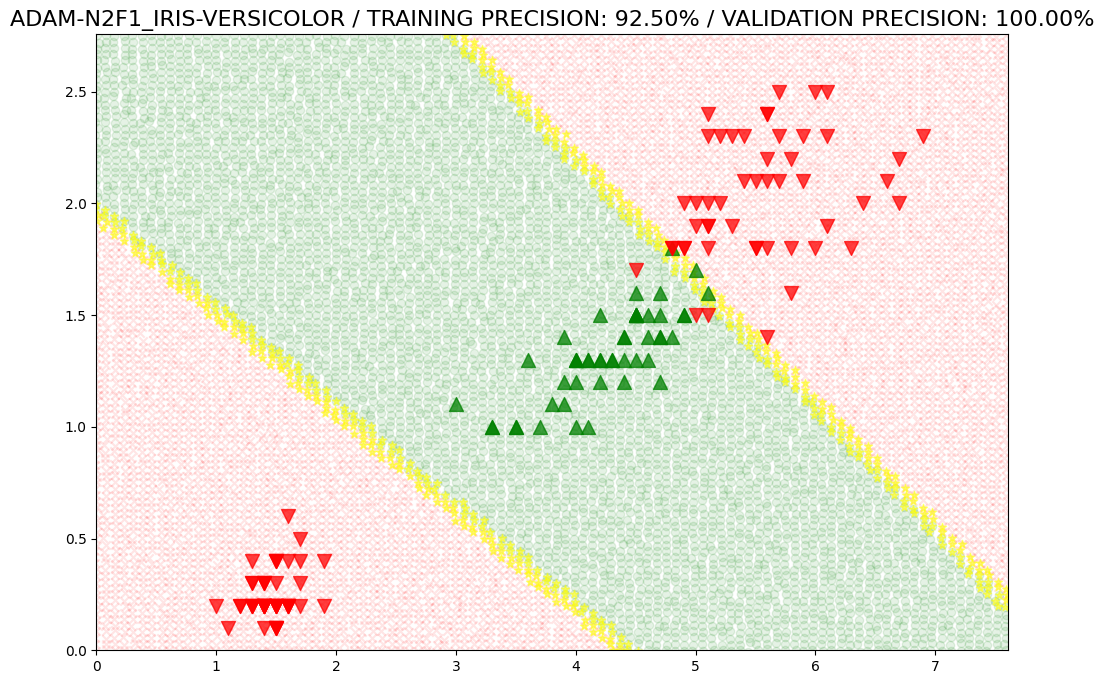

In [114]:
# CLASSIFICATION FIGURE
height = 8
fig = pyplot.figure(figsize=(height/0.68, height))
ax = fig.add_subplot(111)
# PLOT CLASS REGION
ix_class_region = Y_g.reshape(-1) > class_threshold
ix_class_points = Y.reshape(-1) == 1
ix_surface = (Y_g.reshape(-1) >= class_threshold - little_delta) &  (Y_g.reshape(-1) <= class_threshold + little_delta)
_ = ax.scatter(X_g[ix_class_region, 0], X_g[ix_class_region, 1], marker='o', color='green', alpha=0.1)
_ = ax.scatter(X_g[~ix_class_region, 0], X_g[~ix_class_region, 1], marker='x', color='red', alpha=0.1)
_ = ax.scatter(X_g[ix_surface, 0], X_g[ix_surface, 1], marker='*', color='yellow', alpha=0.5)
_ = ax.scatter(X[ix_class_points, 0], X[ix_class_points, 1], marker='^', color='green', alpha=0.75, s=100)
_ = ax.scatter(X[~ix_class_points, 0], X[~ix_class_points, 1], marker='v', color='red', alpha=0.75, s=100)
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title('{} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, metric_name, 100.0*best_metric, metric_name,100.0*best_metric_val).upper(), size=16)